In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate
import scipy.integrate as integrate
import types
import lmfit
from numpy import genfromtxt

# import mpmath

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'white'
np.set_printoptions(precision=15)

# Helper functions

In [3]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

# Classes that define simulated instruments.

In [4]:
class Spectrograph:
    def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
        self.xres = xres
        self.nOrders = nOrders
        self.orderSize = orderSize
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = minWl + orderSize * nOrders
        self.psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.fac = self.xres / self.orderSize # Constantly used in conversions
        self.blaze = blaze
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    
    def blaze_order(self, wlSpace, obs, fsr, mid):
        sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        return obs * np.exp(-(wlSpace - mid) ** 2 / (2.0 * sigma ** 2)) 
    
    def observe(self, beams, orders='all'):
        space = np.empty((self.nOrders, self.xres,))
        observation = np.empty((self.nOrders, self.xres,))
        true_space = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = range(0, self.nOrders)
        
        for i in orders:
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            fsr = endWl - startWl
            mid = np.mean([startWl, endWl])
            order_space = np.linspace(startWl, endWl, self.xres, endpoint=False)
            order_obs = np.zeros(len(order_space))

            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(order_space)) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                for wl in beam:
                    order_obs += gauss(order_space, wl, self.psf_sigma, beam[wl])

            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, len(order_space))
            
            # Blaze
            if self.blaze:
                order_obs = self.blaze_order(order_space, order_obs, fsr, mid)
            
#             plt.scatter(order_space, order_obs)
#             plt.show()
            
            space[i] = np.linspace((i * self.xres), ((i + 1) * self.xres) - 1, self.xres)
            observation[i] = order_obs
            true_space[i] = order_space

        return space, observation, true_space
    
    def pix_to_wl(self, pix):
        return self.minWl + (pix / self.fac)
        
    def wl_to_pix(self, wl):
        return (wl - sgraph.minWl) * self.fac
        
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim

# Generating lamp vs. LFC comparison

3200


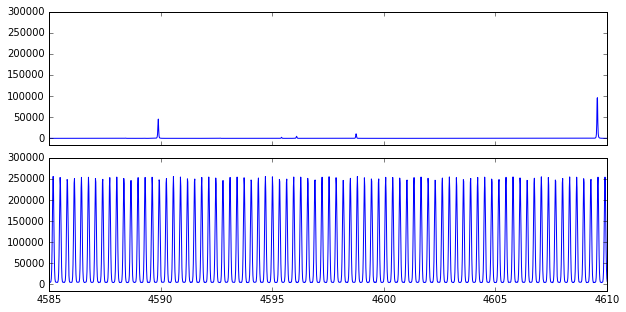

In [30]:
# Get lamp data
lamp_data = genfromtxt('thar.txt', delimiter='\t')
x_lamp = list(zip(*lamp_data)[0])
print(len(x_lamp))
y_lamp = list(zip(*lamp_data)[1])

# Generate spectrograph data
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph(3200, 80, 5.274658, 457.793506, 5000.0, 300.0, 0.0075, 1.0, False)
lfc = LFC(250000, 400, sgraph.maxWl - 1, 11/347.0)
_, ys, xs = sgraph.observe([lfc.simulate()], orders=[0])
x_lfc = xs[0] * 10
y_lfc = ys[0]

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(10,5))
ax1.plot(x_lamp, y_lamp, color='blue')
ax2.plot(x_lfc, y_lfc, color='blue')
ax1.set_xlim(4585, 4610)
ax1.set_ylim(-15000, 300000)
f.subplots_adjust(hspace=0.1)
# plt.ylim(-15000, 300000)
# plt.xlim(4585, 4610)
plt.savefig('../figs/lampvlfc.png', )
